# Beyond-GCR access

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook will show you how to access the DP0.2 object catalog directly through the parquet files at nersc, using the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) to access the file locations and metadata. We will discuss why you may want to do this, and how to do some basic tasks efficiently.


__Learning objectives__:

After going through this notebook, you should be able to:
  1. Access the DP0.2 object catalog directly using parquet functions for more advanced read-in options

__Future additions__:
  1. Get the SRV filters
  2. Add join with truth tables here and some more examples of advanced use cases

__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC


## Why do this?

There are two main reasons we're providing this information. 

- Firstly while we can provide a straightforward read method using the GCR, this has been developed with the intention of being agnostic to data format. However for the object catalogs we can expect these will stay in parquet format, and we find that some DESC members want access to methods which they can access through the parquet file paths or handles, which are not easily translated to other data formats.  

- Secondly there's a question of choice and ease. Some codes may work with direct parquet reads and rewriting them to use the GCR may not be time-effective, and people who are comfortable using parquet files may prefer direct access to better optimize and understand what they're doing. 


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import pyarrow.compute as pc
import pyarrow.dataset as ds
from GCR.utils import concatenate_1d

import time

## Accessing the object catalog metadata with the GCR

The [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs) package is a DESC project which aims at gathering in one convenient location various simulation/data catalogs made available to the collaboration.  

Here we will show you how to access the information on the direct parquet handles and file locations available through the GCR, for the object catalogs from DC2 Run2.2i that the Rubin project ran using the DMStack, DP0.2 (data preview 0.2).


In [3]:
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs

# Load the object catalog
catalog = GCRCatalogs.load_catalog('lsst_object_full')

A significant numbers of cosmology catalogs besides the DP0.2 object catalogs are also available through the GCR, use `sorted(GCRCatalogs.get_available_catalogs(False))` to see a full list and visit the [DC2 Data Product](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview) page to see all the DC2-related catalogs.

### DP0.2 object catalog Schema

The quantities available in the catalog can be found on the project website here: https://dm.lsst.org/sdm_schemas/browser/dp02.html, but we can also access these from the GCR in the following way. Note that these methods are equivalent, for this specific catalog named lsst_object we have done no quantity translation and so it's safe to assume that these follow the lsst conventions exactly. 

Note that for comparisons between the DP0.2 and DC2 object catalogs you may prefer to use a translation layer to convert the DP0.2 catalog into DC2 conventions before read-in, this is available by using dp02_object rather than lsst_object. We will cover the use of the translated catalog in a different tutorial. 


In [4]:
quantity_list = sorted(catalog.list_all_native_quantities())
for i in range(4):
    q = quantity_list[i]
    info = catalog.get_quantity_info(q)
    print(q)
    print('------------------')
    print(info['description'])
    print('Type: ' + info['type'] + ',', 'Units: ' + info['unit'])
    print(' ')

coord_dec
------------------
Fiducial ICRS Declination of centroid used for database indexing
Type: double, Units: deg
 
coord_ra
------------------
Fiducial ICRS Right Ascension of centroid used for database indexing
Type: double, Units: deg
 
deblend_nChild
------------------
Number of children this object has (defaults to 0)
Type: int32, Units: none
 
deblend_skipped
------------------
Deblender skipped this source
Type: boolean, Units: none
 


## Methods to access this dataset

First let's show you how to use GCR to directly access the Parquet file handle. This handle is simply opening the Parquet file as in the code snippet that follows. If there is a use-case in which you need a different access method the file path is also available 


```import pyarrow.parquet as pq```

```handle = pq.ParquetFile(self.path)```


In [5]:
for parquet_data in catalog._datasets[:2]:
    print('Dataset info: ', parquet_data.info)
    print('Dataset handle: ', parquet_data.handle)
    print('Dataset path: ', parquet_data.path)
    print(' ')

Dataset info:  {'tract': 2897}
Dataset handle:  <pyarrow.parquet.core.ParquetFile object at 0x7fb28af00d00>
Dataset path:  /global/cfs/cdirs/lsst/shared/rubin/DP0.2/objectTable/objectTable_tract_2897_DC2_2_2i_runs_DP0_2_v23_0_1_PREOPS-905_step3_1_20220317T233937Z.parq
 
Dataset info:  {'tract': 2898}
Dataset handle:  <pyarrow.parquet.core.ParquetFile object at 0x7fb28aa503d0>
Dataset path:  /global/cfs/cdirs/lsst/shared/rubin/DP0.2/objectTable/objectTable_tract_2898_DC2_2_2i_runs_DP0_2_v23_0_1_PREOPS-905_step3_1_20220308T153907Z.parq
 


### Format notes
- you need to know which filter notation you need, in this case we use pyarrow.compute filters. There's a conversion script between string filters and pyarrow.compute filters below for convenience 

Let's first try an iterative read (reducing memory requirements) and concatenate the results

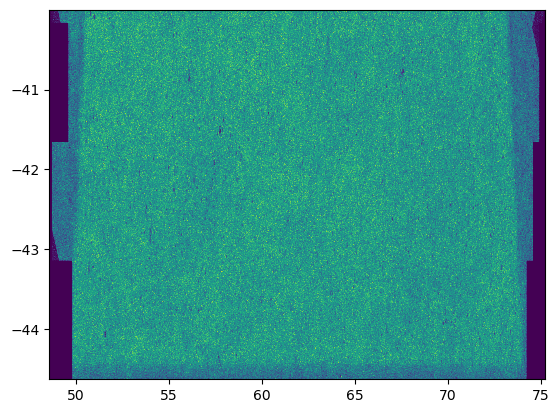

13 seconds to read data


In [21]:
time_start = time.time()

# take the file handles and combine them into a dataset
sources = [parquet_data.path for parquet_data in catalog._datasets]
dataset = ds.dataset(sources)

filter = pc.field('detect_isPrimary')&(pc.field("r_ra") > 0) & (pc.field("r_decl") < -40)

ra_full = []
dec_full = []
for batch in dataset.to_batches(columns=["r_ra","r_decl"], filter=filter,):
    ra_full.append(batch["r_ra"])
    dec_full.append(batch["r_decl"])
time_end = time.time()
ra_full = concatenate_1d(ra_full)
dec_full = concatenate_1d(dec_full)

plt.hist2d(ra_full,dec_full,bins=1000)
plt.show()
print(round(time_end-time_start), 'seconds to read data')

and then a full read into a pyarrow table format (you can just use a .to_pandas() to convert it to a pandas table if you prefer those)

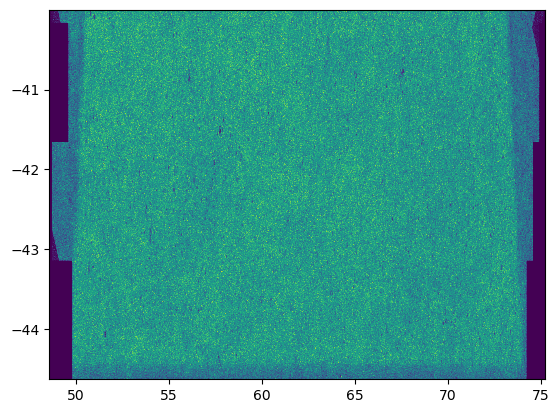

7 seconds to read data


In [6]:
time_start = time.time()

# take the file handles and combine them into a dataset
sources = [parquet_data.path for parquet_data in catalog._datasets]
dataset = ds.dataset(sources)

filter = pc.field('detect_isPrimary')&(pc.field("r_ra") > 0) & (pc.field("r_decl") < -40)
data = dataset.to_table(columns=["r_ra","r_decl"], filter=filter,)

time_end = time.time()

plt.hist2d(data['r_ra'],data['r_decl'],bins=1000)
plt.show()
print(round(time_end-time_start), 'seconds to read data')

pandas_data = data.to_pandas()

### Creating filters
If you're not familiar with pyarrow filters or have a big string of GCR filters and want a conversion script the below should work

In [7]:
import re
import numexpr as ne

def convert_to_pyarrow_filter(filter_list):
    for i in range(len(filter_list)):
        for n in set(ne.necompiler.precompile(filter_list[i])[-1]):
            filter_list[i] = re.sub(rf"\b({n})\b", "pc.field(\"\\1\")", filter_list[i])
    total_query = eval(filter_list[0])
    
    if len(filter_list)>1:
        for i in range(1,len(filter_list)):
            total_query = total_query&eval(filter_list[i])
    return total_query
    
convert_to_pyarrow_filter(['detect_isPrimary', "r_ra > 0", "r_decl < -40"])

<pyarrow.compute.Expression ((detect_isPrimary and (r_ra > 0)) and (r_decl < -40))>

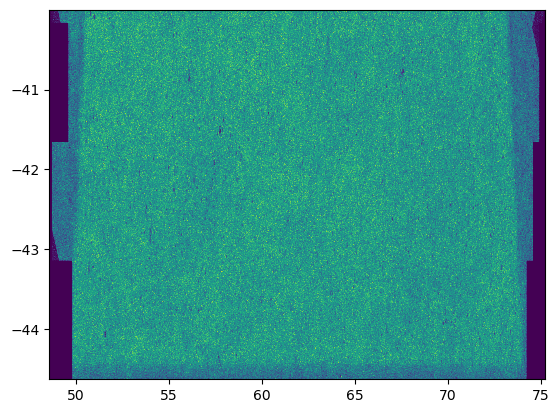

2 seconds to read data


In [8]:
time_start = time.time()

# take the file handles and combine them into a dataset
sources = [parquet_data.path for parquet_data in catalog._datasets]
dataset = ds.dataset(sources)

filter = convert_to_pyarrow_filter(['detect_isPrimary', "r_ra > 0", "r_decl < -40"])
data = dataset.to_table(columns=["r_ra","r_decl"], filter=filter,)

time_end = time.time()

plt.hist2d(data['r_ra'],data['r_decl'],bins=1000)
plt.show()
print(round(time_end-time_start), 'seconds to read data')


### Catalog Filters

This section is in development, but you will be able to see filters that are being applied through quantity modifiers and convert them to pyarrow filters. Currently to get all the flags that I apply by default you should use the get_quantity_modifier for flags_good and flags_bad and you can convert them into a pyarrow filter as follows. 

In the future this will encompass the rest of the cuts as noticed in the SRV release section. 

In [41]:
print(catalog.get_quantity_modifier('flags_good'))
print(catalog.get_quantity_modifier('flags_bad'))

(<function create_true_flag_mask at 0x7fb28aca4a60>, 'detect_isPrimary')
(<function create_false_flag_mask at 0x7fb28ac13e20>, 'i_pixelFlags_bad', 'i_pixelFlags_sensor_edgeCenter', 'i_pixelFlags_offimage', 'i_pixelFlags_clippedCenter', 'i_pixelFlags_crCenter', 'i_pixelFlags_interpolatedCenter', 'i_pixelFlags_inexact_psfCenter', 'i_pixelFlags_edge', 'i_pixelFlags_suspectCenter', 'i_pixelFlags_saturatedCenter', 'i_pixelFlags_clipped', 'i_pixelFlags_cr', 'i_pixelFlags_interpolated', 'i_pixelFlags_saturated', 'i_pixelFlags_sensor_edge', 'i_pixelFlags_suspect', 'deblend_skipped', 'i_centroid_flag', 'i_cModel_flag', 'i_gaapFlux_flag', 'i_i_flag', 'i_iPSF_flag', 'i_hsmShapeRegauss_flag', 'i_blendedness_flag')


In [42]:
filter_list = [flag + '==False' for flag in catalog.get_quantity_modifier('flags_bad')[1:]]
filter_list += [flag for flag in catalog.get_quantity_modifier('flags_good')[1:]]
filter_list_pyarrow = convert_to_pyarrow_filter(filter_list)

## Advanced tools

With parquet datasets you can use some more advanced tooling through the compute tool. Let's say you want to combine two datasets, like the object catalog and the truth match catalog. You can do that through the join function.  

import pyarrow.dataset as ds

ds1 = ds.dataset(table1)
ds2 = ds.dataset(table2)

joined_ds = ds1.join(ds2, key="id")

You can create a scanner over the data, where the scanner doesn't run immediately but exposes the ability to run and then apply other methods. This can be especially useful for applying extra filters. 

dataset.scanner(filter=ds.field("year") > 2020).to_table()

You can acess the acero framework to do operations over batched data in an efficient way (which underlies the dataset methods). But if you do so you should note that:

*"Acero is not intended to be used directly by data scientists. It is expected that end users will typically be using some kind of frontend. For example, Pandas, Ibis, or SQL. The API for Acero is focused around capabilities and available algorithms. However, such users may be interested in knowing more about how Acero works so that they can better understand how the backend processing for their libraries operates."*

